In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import cartopy.crs as crs
import cartopy.feature as cfeature

In [2]:
%matplotlib inline
# Use 3 decimal places in output display
pd.set_option("display.precision", 3)
# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)
# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

The data is loaded into a DataFrame with 12043 rows and 23 columns.

In [3]:
df = pd.read_excel("ANZ synthesised transaction dataset.xlsx")

In [4]:
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [5]:
len(df)

12043

In [6]:
df.dtypes

status                       object
card_present_flag           float64
bpay_biller_code             object
account                      object
currency                     object
long_lat                     object
txn_description              object
merchant_id                  object
merchant_code               float64
first_name                   object
balance                     float64
date                 datetime64[ns]
gender                       object
age                           int64
merchant_suburb              object
merchant_state               object
extraction                   object
amount                      float64
transaction_id               object
country                      object
customer_id                  object
merchant_long_lat            object
movement                     object
dtype: object

In [7]:
# There are only 2 statuses of the transactions: authorized and posted. Authorized transactions are more than posted 
# transactions.
df['status'].value_counts(dropna=False)

authorized    7717
posted        4326
Name: status, dtype: int64

In [8]:
# This field may indicate whether a transaction was made with card or online. Transactions made with card are ~4 times the
# number of transactions made online. There are 4326 transactions with this piece of information missing.
df['card_present_flag'].value_counts(dropna=False)

1.0    6194
NaN    4326
0.0    1523
Name: card_present_flag, dtype: int64

In [9]:
# This column may contain information about bill payees. But most transactions don't have this information recorded.
df['bpay_biller_code'].value_counts(dropna=False)

NaN                                      11158
0                                          883
 LAND WATER & PLANNING East Melbourne        1
 THE DISCOUNT CHEMIST GROUP                  1
Name: bpay_biller_code, dtype: int64

In [10]:
# The ANZ website mentions that This task is based on a synthesised transaction dataset containing 3 months’ worth of 
# transactions for 100 hypothetical customers, agreeing with the number of unique accounts.
print(df['account'].nunique())

# All the accounts follow the pattern "ACC-a series of numbers". The series of numbers can be 8, 9, or 10 numbers long.
pattern = re.compile('ACC-(\d+)')
account_number_length = set()
for i in range(len(df)):
    m = pattern.search(df.loc[i]['account'])
    if m is None:
        print(i, df.loc[i]['account'])
    else:
        account_number_length.add(len(m.group(1)))
print(account_number_length)

100
{8, 9, 10}


In [11]:
# All transactions were made in AUD.
df['currency'].value_counts()

AUD    12043
Name: currency, dtype: int64

In [12]:
# All transactions have the longitude and latitude information available
sum(df['long_lat'].isnull())

0

In [46]:
df['txn_description'].value_counts(dropna=False, normalize=True)

SALES-POS     0.327
POS           0.314
PAYMENT       0.216
PAY/SALARY    0.073
INTER BANK    0.062
PHONE BANK    0.008
Name: txn_description, dtype: float64

In [14]:
# All accounts have a valid balance. The minimum value is 0.24, the maximum value is 267128.52, the average value is 14704.20,
# the median value is 6432.01.
print(sum(df['balance'].isnull()))
print(df['balance'].describe())

0
count     12043.000
mean      14704.196
std       31503.723
min           0.240
25%        3158.585
50%        6432.010
75%       12465.945
max      267128.520
Name: balance, dtype: float64


In [15]:
# All transactions were distributed over the three-month period 2018-08-01 to 2018-10-31. There are 91 unique date values, 
# indicating that transactions took place almost every day. 2018-09-28 had the most transactions/day (174 transactions).
df['date'].describe()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                   12043
unique                     91
top       2018-09-28 00:00:00
freq                      174
first     2018-08-01 00:00:00
last      2018-10-31 00:00:00
Name: date, dtype: object

In [16]:
df['gender'].value_counts(dropna=False)

M    6285
F    5758
Name: gender, dtype: int64

In [17]:
df['age'].describe()

count    12043.000
mean        30.582
std         10.046
min         18.000
25%         22.000
50%         28.000
75%         38.000
max         78.000
Name: age, dtype: float64

In [18]:
# The merchants involved in these transactions come from 1609 suburbs and 8 states in Australia
df[['merchant_suburb', 'merchant_state']].nunique()

merchant_suburb    1609
merchant_state        8
dtype: int64

In [19]:
# Extractions are the exact time stamp when a transaction is made.
df['extraction'].head(10)

0    2018-08-01T01:01:15.000+0000
1    2018-08-01T01:13:45.000+0000
2    2018-08-01T01:26:15.000+0000
3    2018-08-01T01:38:45.000+0000
4    2018-08-01T01:51:15.000+0000
5    2018-08-01T02:00:00.000+0000
6    2018-08-01T02:23:04.000+0000
7    2018-08-01T04:11:25.000+0000
8    2018-08-01T04:40:00.000+0000
9    2018-08-01T06:00:00.000+0000
Name: extraction, dtype: object

In [20]:
# The average transaction amount is 187.93 AUD.
df['amount'].describe()

count    12043.000
mean       187.934
std        592.600
min          0.100
25%         16.000
50%         29.000
75%         53.655
max       8835.980
Name: amount, dtype: float64

In [21]:
df['transaction_id'].nunique()

12043

In [22]:
df['country'].value_counts(dropna=False)

Australia    12043
Name: country, dtype: int64

In [23]:
# The average number of transactions per account is 120.43.
account_gb = df.groupby('account', as_index=False)
account_gb_ti = account_gb['transaction_id'].count().rename(columns={'transaction_id':'ti_count'})
print(account_gb_ti.head())
print(account_gb_ti['ti_count'].mean())

          account  ti_count
0  ACC-1037050564       259
1  ACC-1056639002        86
2  ACC-1199531521        77
3  ACC-1217063613        25
4  ACC-1222300524       303
120.43


In [24]:
df['movement'].value_counts(dropna=False)

debit     11160
credit      883
Name: movement, dtype: int64

In [25]:
# The average number of transactions per month is 4014.33
df['month'] = pd.DatetimeIndex(df['date']).month
month_gb = df.groupby('month', as_index=False)
month_gb_ti = month_gb['transaction_id'].count().rename(columns={'transaction_id':'ti_count'})
print(month_gb_ti.head())
print(month_gb_ti['ti_count'].mean())

   month  ti_count
0      8      3943
1      9      4013
2     10      4087
4014.3333333333335


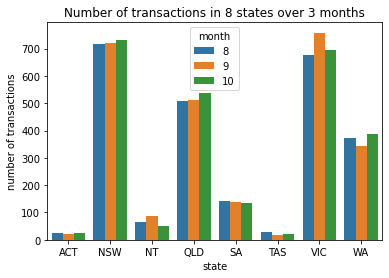

In [52]:
month_state_gb = df.groupby(['month', 'merchant_state'], as_index=False)
month_state_gb_ti = month_state_gb['transaction_id'].count().rename(columns={'transaction_id':'ti_count'})

g = sns.barplot(x='merchant_state', y= 'ti_count', data=month_state_gb_ti, hue='month')
plt.ylabel('number of transactions')
plt.xlabel('state')
plt.title('Number of transactions in 8 states over 3 months')
plt.savefig('transaction_count_by_state_month')
plt.show()

In [27]:
df['weekday'] = df['date'].dt.dayofweek
weekday_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['weekday'] = df['weekday'].map(weekday_map)
print(df['weekday'].value_counts())
df['hour'] = df['extraction'].str.slice(start=11, stop=13).astype(int)
print(df['hour'].unique())

Fri    2073
Wed    2063
Thu    1801
Sat    1709
Sun    1550
Tue    1487
Mon    1360
Name: weekday, dtype: int64
[ 1  2  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  3  5]


  weekday  ti_count  avg_ti_count
0     Fri      2073       159.462
1     Mon      1360       104.615
2     Sat      1709       131.462
3     Sun      1550       119.231
4     Thu      1801       138.538
5     Tue      1487       114.385
6     Wed      2063       147.357


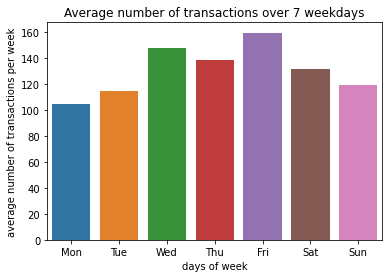

In [48]:
weekday_gb = df.groupby('weekday', as_index=False)
weekday_gb_ti = weekday_gb['transaction_id'].count().rename(columns={'transaction_id':'ti_count'})
# There were 14 Wednesdays, 13 other weekdays from 2018-08-01 to 2018-10-31
weekday_gb_ti['avg_ti_count'] = weekday_gb_ti['ti_count']/pd.Series([13,13,13,13,13,13,14])
print(weekday_gb_ti)
sns.barplot(x='weekday', y='avg_ti_count', data=weekday_gb_ti, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('average number of transactions per week')
plt.xlabel('days of week')
plt.title('Average number of transactions over 7 weekdays')
plt.savefig('average_transaction_count_by_weekday')
plt.show()

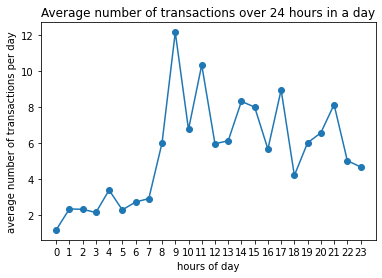

In [49]:
hour_gb = df.groupby('hour', as_index=False)
hour_gb_ti = hour_gb['transaction_id'].count().rename(columns={'transaction_id':'ti_count'})
hour_gb_ti['avg_ti_count'] = hour_gb_ti['ti_count'] / 91
plt.plot(hour_gb_ti['hour'], hour_gb_ti['avg_ti_count'], marker='o')
#sns.lineplot(x='hour', y='avg_ti_count', data=hour_gb_ti, style='avg_ti_count', markers=True)
plt.xticks(range(24))
plt.ylabel('average number of transactions per day')
plt.xlabel('hours of day')
plt.title('Average number of transactions over 24 hours in a day')
plt.savefig('average_transaction_count_by_hour')
plt.show()

In [30]:
# Geospatial information about the accounts
account_long_lat = df['long_lat'].str.split(' ', n=1, expand=True)
df['account_long'] = account_long_lat[0].astype(float)
df['account_lat'] = account_long_lat[1].astype(float)
print(df['account_long'].max(), df['account_long'].min(), df['account_lat'].max(), df['account_lat'].min())

255.0 114.62 -12.37 -573.0


In [31]:
# The value range of account longitudes and latitudes are not correct. Outliers need to be identified.
# Looks like these faulty values all come from one account. It could be error inputing this piece of info for this account
account_long_outliers = df[df['account_long'] > 180]
display(account_long_outliers.head())
print(account_long_outliers['account'].value_counts(dropna=False))
print(account_long_outliers['account_lat'].value_counts())
print(account_long_outliers['amount'].value_counts())

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,transaction_id,country,customer_id,merchant_long_lat,movement,month,weekday,hour,account_long,account_lat
47,authorized,0.0,NaN,ACC-2901672282,AUD,255.00 -573.00,SALES-POS,7ce5471b-363c-46ab-b398-ca517347829a,NaN,Daniel,...,826f09d26daf4b7282f597cabfecaf81,Australia,CUS-1617121891,151.21 -33.87,debit,8,Wed,10,255.0,-573.0
51,posted,NaN,NaN,ACC-2901672282,AUD,255.00 -573.00,PAYMENT,NaN,NaN,Daniel,...,62e49c215d7e45609556936fd7e860ce,Australia,CUS-1617121891,NaN,debit,8,Wed,11,255.0,-573.0
99,posted,NaN,NaN,ACC-2901672282,AUD,255.00 -573.00,PAYMENT,NaN,NaN,Daniel,...,c539e04478c94bb2b48af6e0069a011b,Australia,CUS-1617121891,NaN,debit,8,Wed,17,255.0,-573.0
392,posted,NaN,0,ACC-2901672282,AUD,255.00 -573.00,PAY/SALARY,NaN,0.0,Daniel,...,035f7e013df6486f80e2245bea04a28f,Australia,CUS-1617121891,NaN,credit,8,Fri,17,255.0,-573.0
473,authorized,1.0,NaN,ACC-2901672282,AUD,255.00 -573.00,POS,ac9555e4-9c7c-486b-9e65-07e2e918dd0b,NaN,Daniel,...,9467d030d2b84b4dbc419e8230fd9361,Australia,CUS-1617121891,145.09 -37.9,debit,8,Sat,9,255.0,-573.0


ACC-2901672282    123
Name: account, dtype: int64
-573.0    123
Name: account_lat, dtype: int64
33.00      14
40.00      13
3328.77     7
95.00       3
106.00      3
           ..
23.09       1
47.82       1
60.39       1
51.80       1
41.10       1
Name: amount, Length: 86, dtype: int64


In [32]:
account_right_long_lat = df[(df['account_long'] < 180) & (df['account_lat'] > -90)]
print(len(account_right_long_lat))
print(account_right_long_lat['account_long'].max(), account_right_long_lat['account_long'].min(), 
      account_right_long_lat['account_lat'].max(), account_right_long_lat['account_lat'].min())

11920
153.41 114.62 -12.37 -42.88


In [40]:
# Geospatial information about the merchants
merchant_long_lat = df['merchant_long_lat'].str.split(' ', n=1, expand=True)
df['merchant_long'] = merchant_long_lat[0].astype(float)
df['merchant_lat'] = merchant_long_lat[1].astype(float)
print(df['merchant_long'].max(), df['merchant_long'].min(), df['merchant_lat'].max(), df['merchant_lat'].min())

153.61 113.83 -12.33 -43.31


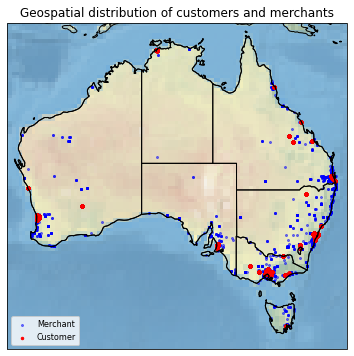

In [50]:
figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(1,1,1, projection=crs.Mercator())
# adds a stock image as a background
ax.stock_img()
# adds national borders
ax.add_feature(cfeature.BORDERS)
# add coastlines
ax.add_feature(cfeature.COASTLINE)
# add state boundaries
ax.add_feature(cfeature.STATES)
# Zoom in on Australia by setting longitude/latitude parameters
ax.set_extent(
    [
        112, # min longitude
        155, # max longitude
        -45, # min latitude
        -9 # max latitude
    ],
    crs=crs.PlateCarree()
)
sc1 = plt.scatter(
    x=df['merchant_long'],
    y=df['merchant_lat'],
    color="blue",
    s=4,
    alpha=0.5,
    transform=crs.PlateCarree()
)
sc2 = plt.scatter(
    x=account_right_long_lat['account_long'],
    y=account_right_long_lat['account_lat'],
    color="red",
    s=6,
    alpha=1,
    transform=crs.PlateCarree()
)
sc3 = plt.scatter(
    x=)
ax.legend((sc1, sc2),
         ('Merchant', 'Customer'),
          loc='lower left',
          fontsize=8)
plt.title('Geospatial distribution of customers and merchants')
plt.savefig('accounts_and_merchants_geoinfo.png')
plt.show()